### Introducation

Clonesize m2 The average blueberry clone size in the field

Honeybee bees/m2/min Honeybee density in the field

Bumbles bees/m2/min Bumblebee density in the field

Andrena bees/m2/min Andrena bee density in the field

Osmia bees/m2/min Osmia bee density in the field

MaxOfUpperTRange ℃ The highest record of the upper band daily air temperature during the bloom season

MinOfUpperTRange ℃ The lowest record of the upper band daily air temperature

AverageOfUpperTRange ℃ The average of the upper band daily air temperature

MaxOfLowerTRange ℃ The highest record of the lower band daily air temperature

MinOfLowerTRange ℃ The lowest record of the lower band daily air temperature

AverageOfLowerTRange ℃ The average of the lower band daily air temperature

RainingDays Day The total number of days during the bloom season, each of which has precipitation larger than zero

AverageRainingDays Day The average of raining days of the entire bloom season



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Define the LightGBM model

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
org = pd.read_csv("data/original.csv")
print("Train data shape: ",train.shape)
print("Test data shape: ",test.shape)
print("Original data shape",org.shape)

Train data shape:  (15289, 18)
Test data shape:  (10194, 17)
Original data shape (777, 18)


In [3]:
train.isnull().sum()

id                      0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

In [4]:
train.duplicated().sum()

0

In [5]:
train['id'].duplicated().sum()

0

In [6]:
train.describe()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,7644.000000,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999
std,4413.698468,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610
25%,3822.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510
50%,7644.000000,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900
75%,11466.000000,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380
max,15288.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401840


### EDA

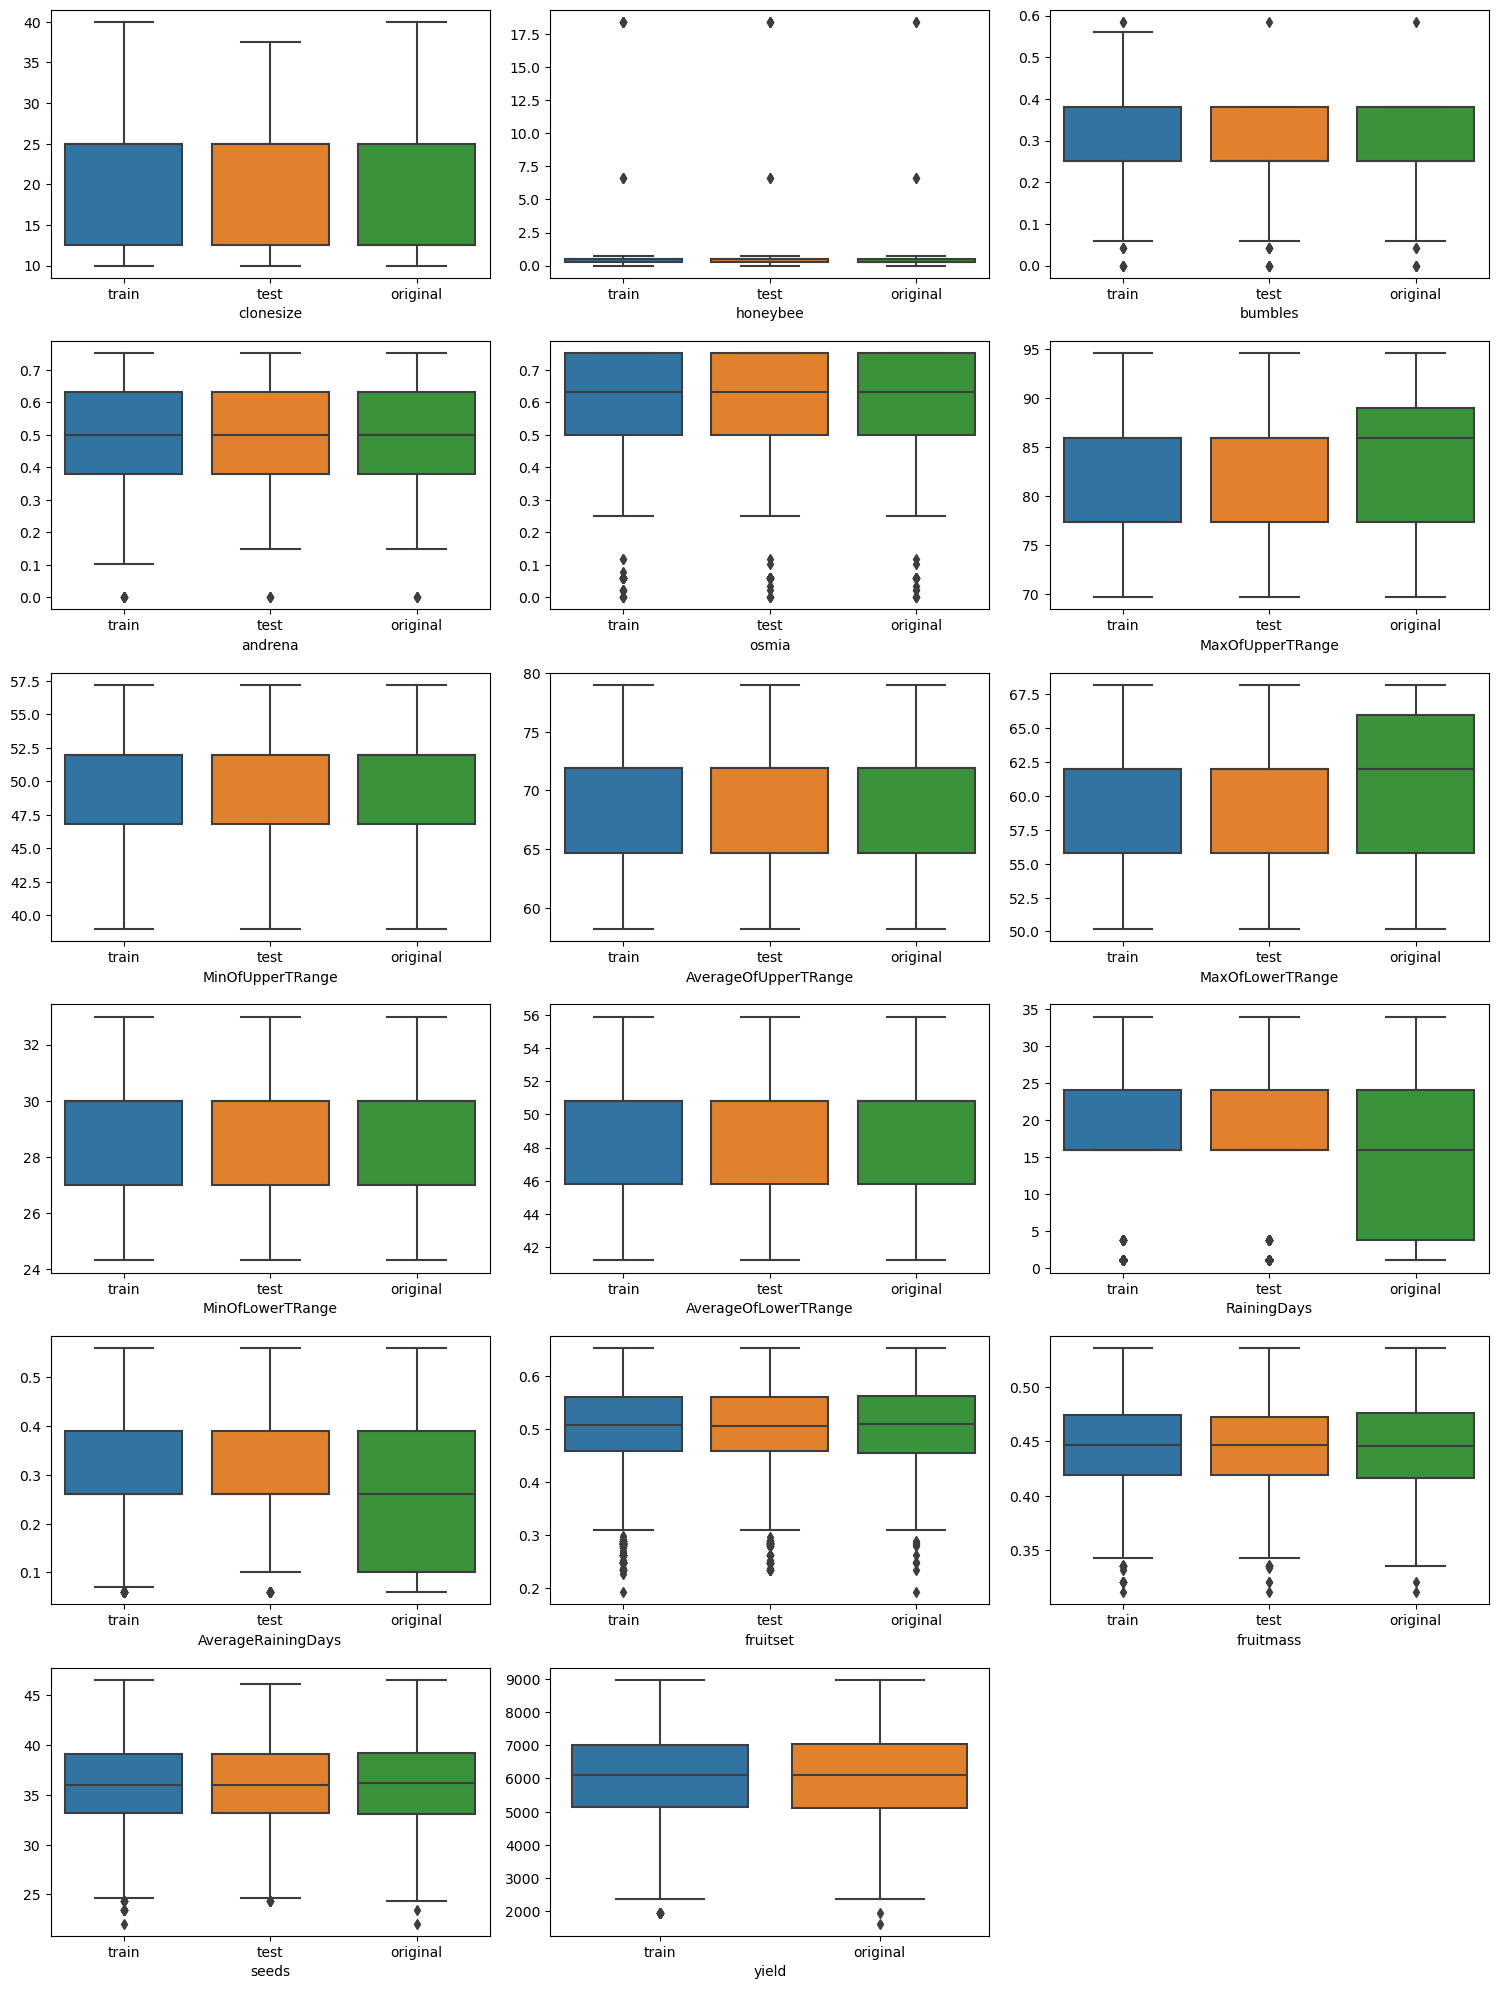

In [7]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
for i, column in enumerate(train.columns[1:]):
    row = i // 3
    col = i % 3
    if column != 'yield':
        tmp_data = pd.DataFrame({"train": train[column], "test": test[column], "original": org[column]})
        sns.boxplot(data=tmp_data, ax=axs[row,col])
    else:
        tmp_data = pd.DataFrame({"train": train[column], "original": org[column]})
        sns.boxplot(data=tmp_data, ax=axs[row,col])
    
    axs[row,col].set_xlabel(column)

fig.delaxes(axs[5,2])
plt.tight_layout()
plt.show()

#### (honeybee column has an outliers for each dataset) well delete it as it may make the model based
#### as (Raining days and Average raining days ) train and test has outliers while original data has no ouliers will de;ete it

In [8]:
def delete_outliers(df,cols):
    
    threshold = 3

    z_scores = np.abs((df[cols] - df[cols].mean()) / df[cols].std())

    df_clean = df[(z_scores < threshold).all(axis=1) | ~df[cols].notnull().any(axis=1)]
    
    return df_clean

In [9]:
print("length of train data before removing outliers",len(train))
train = delete_outliers(train,['honeybee','RainingDays','AverageRainingDays'])
print("length of train data after removing outliers",len(train))

length of train data before removing outliers 15289
length of train data after removing outliers 15281


#### plot histgrom to see distribution of data

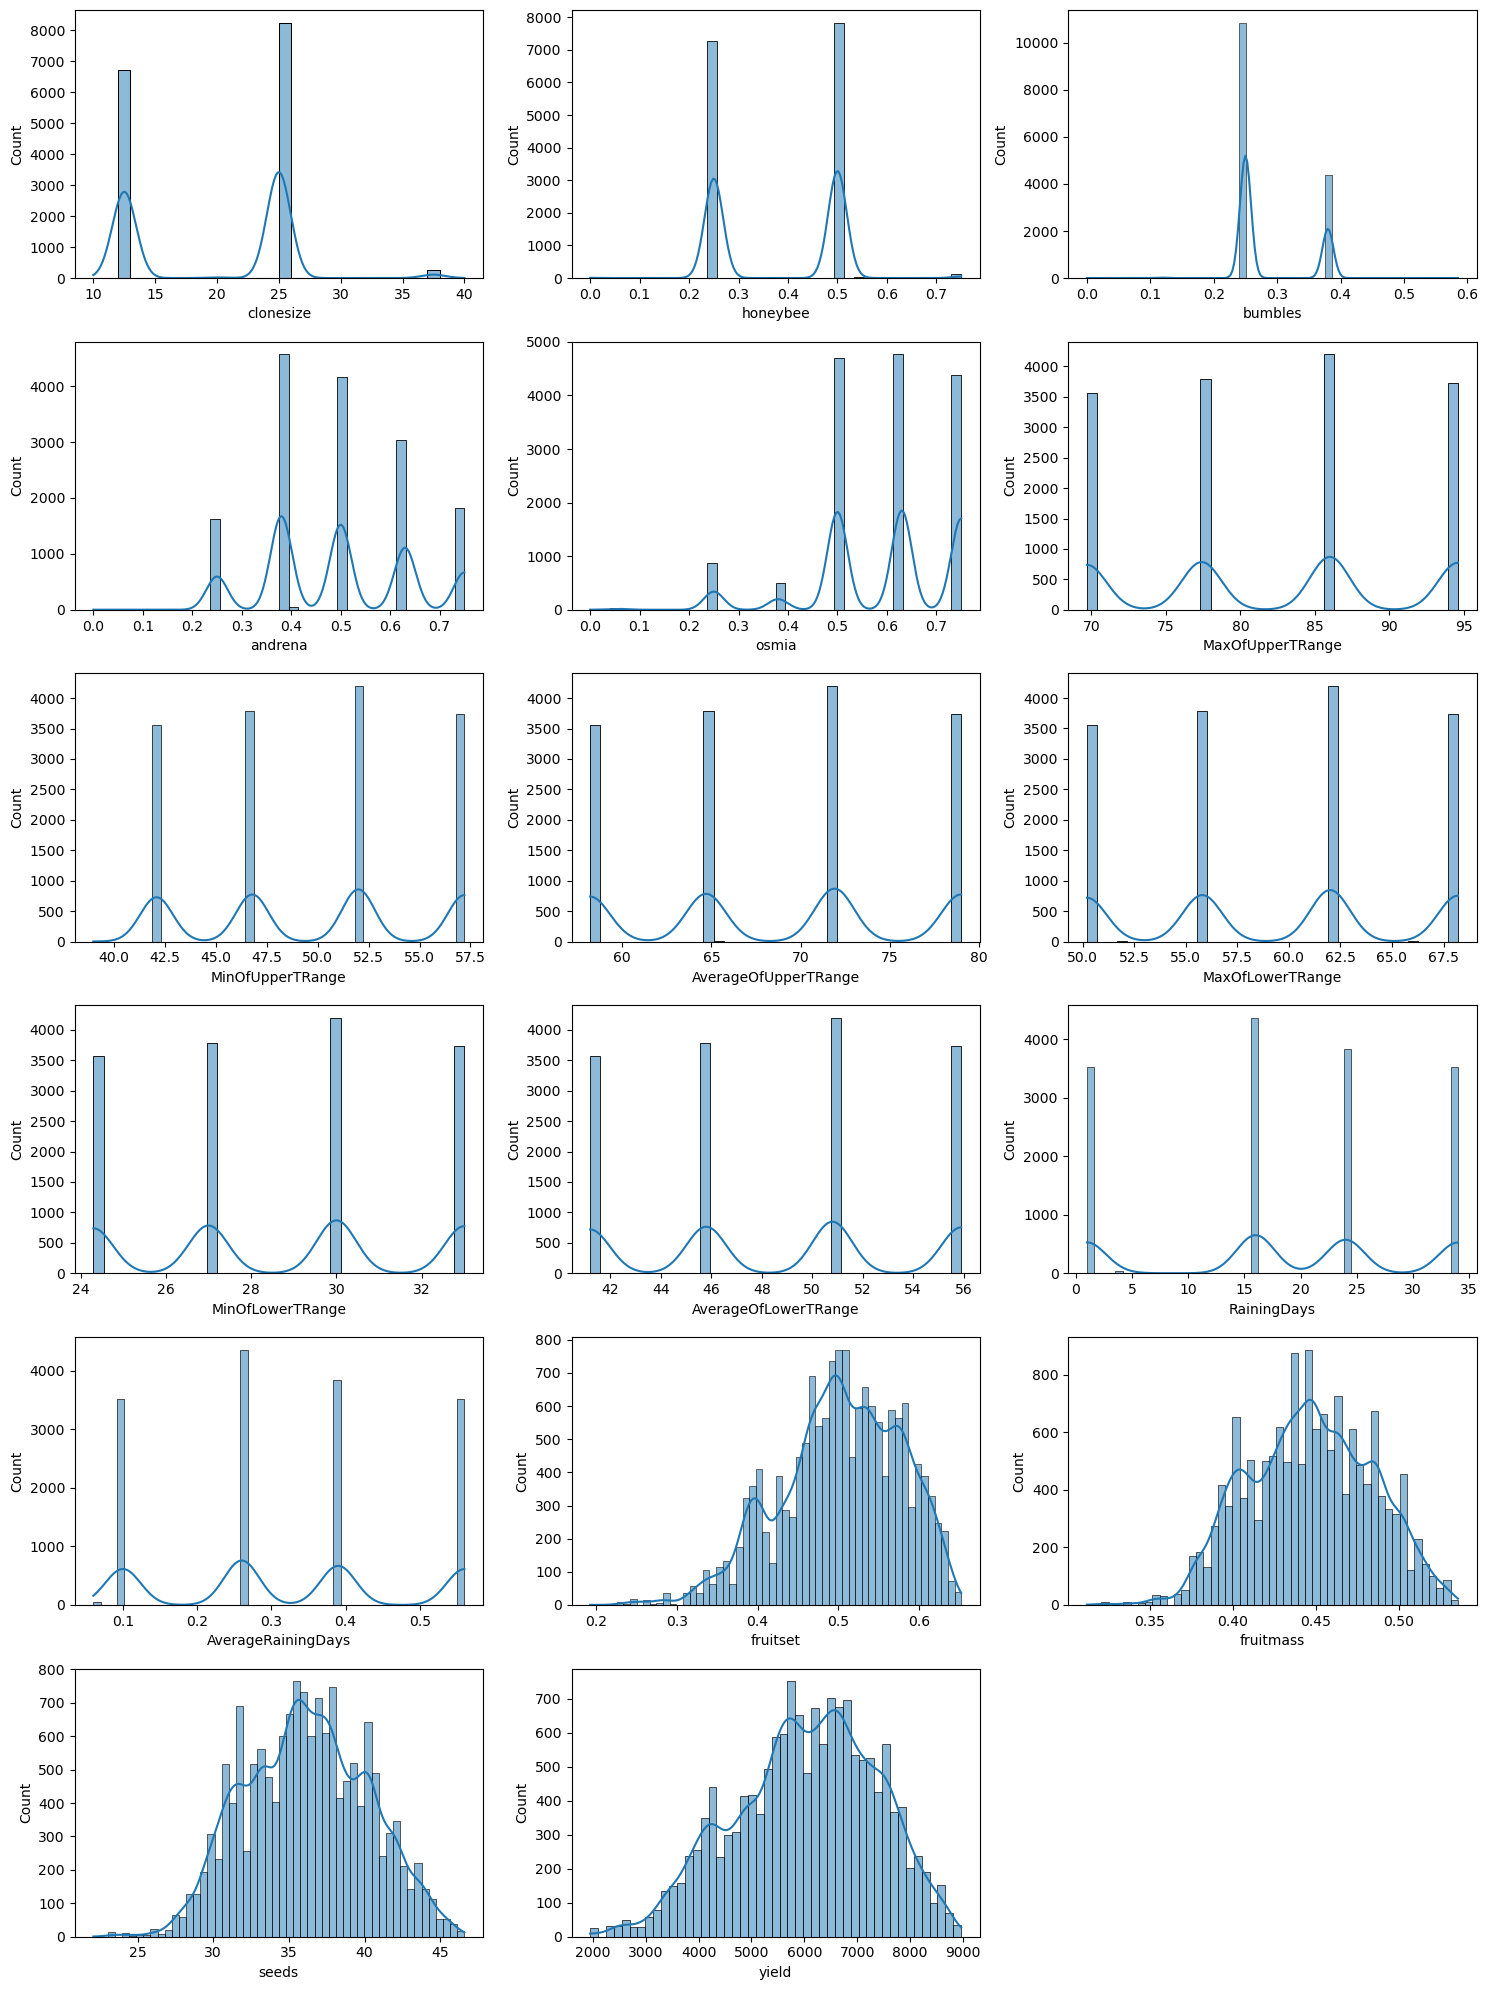

In [10]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
for i, column in enumerate(train.columns[1:]):
    row = i // 3
    col = i % 3
    
    sns.histplot(data=train[column], ax=axs[row,col] ,kde=True)
    axs[row,col].set_xlabel(column)

fig.delaxes(axs[5,2])
plt.tight_layout()
plt.show()

#### the columns untill the RainingAverageDay column has static values 
#### the last for columns has continus valus ,the data is looks normal distributed

#### look at the relation between continus variables

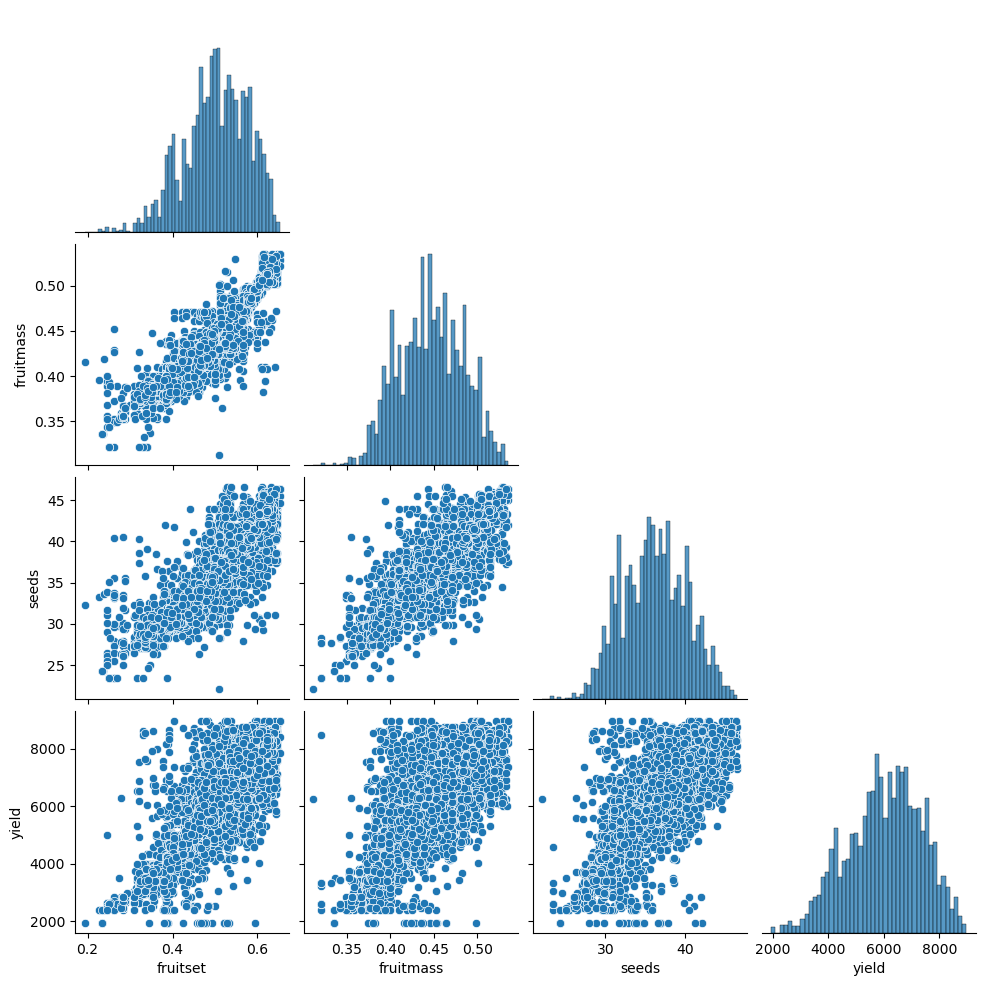

In [11]:
sns.pairplot(data = train.iloc[:,14:],corner = True)
plt.show()

#### the last 3 columns (fruitset ,fruitmass,seeds) features have a positive corrletion with yield target and between eachother

#### let's see the correlation between all features and target

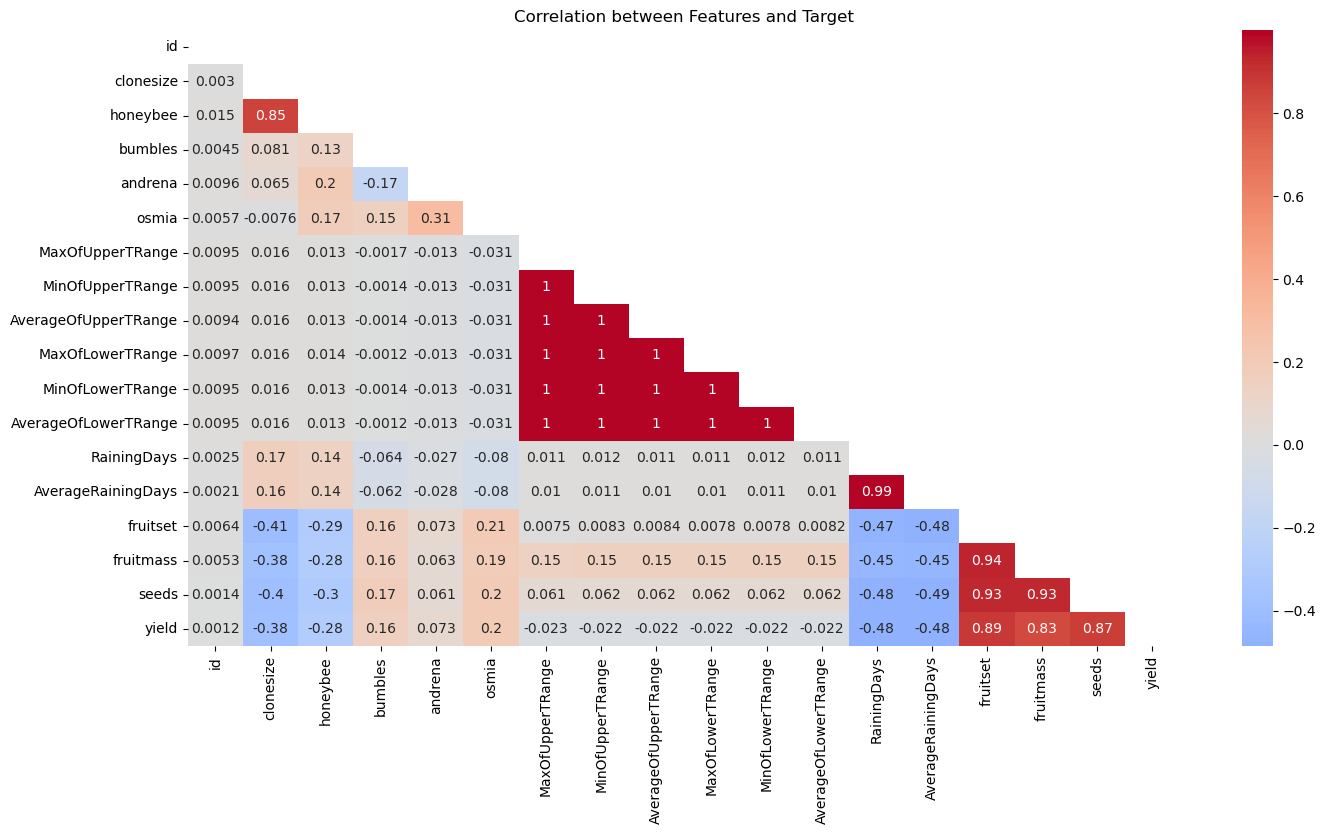

In [12]:
corr = train.corr()

mask = np.zeros_like(corr)
tringle = np.triu_indices_from(mask)
mask[tringle]=True

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(corr, mask = mask,annot=True, cmap='coolwarm', center=0, ax=ax)
ax.set_title('Correlation between Features and Target')
plt.show()

#### we can see (clonesize,RainingDays,AverageRainingDays) features have negtive correlation with yield target while (fruitset ,fruitmass,seeds) features have a positive corrletion with yield target and between eachother

### Build the model

##### Baseline Model

In [13]:
models_scores = pd.DataFrame(columns = ['Model','CrossValScore','PLScore'])

In [14]:
y = train.iloc[:,17]

train.drop(columns=['yield'],inplace=True)
X = train.iloc[:,1:]

In [17]:
param_distributions = {'fit_intercept': [True, False],
                       'normalize': [True, False],
                       'copy_X': [True, False]}

model = LinearRegression()

random_search = RandomizedSearchCV(model, param_distributions=param_distributions, 
                                   n_iter=100, cv=5, random_state=42,
                                  scoring='neg_mean_absolute_error')

random_search.fit(X, y)

best_params = random_search.best_params_


print("Best parameters:", best_params)
print("Best score:", -random_search.best_score_)

Best parameters: {'normalize': True, 'fit_intercept': True, 'copy_X': True}
Best score: 372.70920869573206


In [18]:
def train_cv(model,X,y):
    
    kf = KFold(n_splits=5,shuffle=True,random_state=42)

    MAE = []

    for train_index,valid_index in kf.split(X):

        X_train,X_valid = X.iloc[train_index] ,X.iloc[valid_index]
        model.fit(X_train,y.iloc[train_index])

        y_valid_pred = lr.predict(X_valid)
        mae = mean_absolute_error(y.iloc[valid_index],y_valid_pred)

        MAE.append(mae)
    
    return MAE

In [19]:
lr = LinearRegression(**best_params)
cv_scores = train_cv(lr,X,y)

In [20]:
cv_scores_df = pd.DataFrame({'fold':list(range(1,6)),'linear_regression_cv':cv_scores})
cv_scores_df

,fold,linear_regression_cv
0,1,387.369044
1,2,364.688936
2,3,379.878035
3,4,361.993680
4,5,365.443231


### first submision

In [19]:
lr = LinearRegression(**best_params)

lr.fit(X,y)

test_pred = lr.predict(test.iloc[:,1:])

In [20]:
df_test_pred = test
df_test_pred['yield'] = test_pred
df_test_pred[['id','yield']].to_csv("data/first_submission.csv",index = False)

test.drop(columns = ['yield'],inplace=True)

In [21]:
models_scores.loc[len(models_scores.index)] = ['linear regression',np.mean(cv_scores),363.24883]
models_scores

,Model,CrossValScore,PLScore
0,linear regression,371.874585,363.24883


#### Baseline Model 2

In [22]:
model = XGBRegressor()

param_dist = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [50, 100, 200]
}

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=10,
    cv=5, scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    verbose=2, n_jobs=-1, random_state=42
)

random_search.fit(X, y)

xgbr_best_params = random_search.best_params_

print("Best parameters: ", xgbr_best_params)
print("Mean cross-validation score: ", -1 * random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Mean cross-validation score:  354.66547879628337


In [23]:
xgbr = XGBRegressor(**xgbr_best_params)
xgbr_cv_scores = train_cv(xgbr,X,y)

In [24]:
cv_scores_df['XGBRegressor'] = xgbr_cv_scores
cv_scores_df

,fold,linear_regression_cv,XGBRegressor
0,1,387.369044,386.718582
1,2,364.688936,362.805572
2,3,379.878035,379.014047
3,4,361.993680,360.827692
4,5,365.443231,365.443231


#### second submission

In [27]:
xgbr = XGBRegressor(**xgbr_best_params)

xgbr.fit(X,y)

test_pred = xgbr.predict(test.iloc[:,1:])

In [28]:
df_test_pred = test
df_test_pred['yield'] = test_pred
df_test_pred[['id','yield']].to_csv("data/second_submission.csv",index = False)

test.drop(columns = ['yield'],inplace=True)

In [25]:
models_scores.loc[len(models_scores.index)] = ['XGBRegressor',np.mean(xgbr_cv_scores),348.61419]
models_scores

,Model,CrossValScore,PLScore
0,linear regression,371.874585,363.24883
1,XGBRegressor,370.961825,348.61419


#### the cross validation scores between linear regression model model and XGBRegressor model is so close but XGBRegressor has higher leader board score I will use can merge between the 2 models can extract feature importance like XGBoost and train an easir model like linear regression (lightGBM)

#### Baseline model 3

In [15]:
model = lgb.LGBMRegressor()

# Define the hyperparameter grid
search_spaces = {
    'reg_sqrt': Categorical([True, False]),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     
    'n_estimators': Integer(30, 5000),                   
    'num_leaves': Integer(2, 512),                       
    'max_depth': Integer(-1, 256),                       
    'subsample': Real(0.01, 1.0, 'uniform'),            
    'subsample_freq': Integer(1, 10),                    
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       
   }

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    scoring='neg_mean_absolute_error',
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=0,
)

bayes_search.fit(X, y)

lgbr_best_params = bayes_search.best_params_

print("Best Parameters: ", lgbr_best_params)
print("Cross-validation MAE: ", -bayes_search.best_score_)

Best Parameters:  OrderedDict([('colsample_bytree', 0.6929516086774844), ('learning_rate', 0.020953528585063864), ('max_depth', -1), ('n_estimators', 1388), ('num_leaves', 214), ('reg_alpha', 100.0), ('reg_lambda', 1e-09), ('reg_sqrt', True), ('subsample', 0.3941931478582094), ('subsample_freq', 5)])
Cross-validation MAE:  356.4263129704999


In [26]:
lgbr_model = lgb.LGBMRegressor(**lgbr_best_params)
lgbr_cv_scores = train_cv(lgbr_model,X,y)

In [27]:
cv_scores_df['LGBMRegressor'] = lgbr_cv_scores
cv_scores_df

,fold,linear_regression_cv,XGBRegressor,LGBMRegressor
0,1,387.369044,386.718582,386.718582
1,2,364.688936,362.805572,362.805572
2,3,379.878035,379.014047,379.014047
3,4,361.993680,360.827692,360.827692
4,5,365.443231,365.443231,365.443231


### Third submission

In [28]:
lgbr = lgb.LGBMRegressor(**lgbr_best_params)

lgbr.fit(X,y)

test_pred = lgbr.predict(test.iloc[:,1:])

In [39]:
test['yield'] = test_pred
test[['id','yield']].to_csv("data/third_submission.csv",index = False)

test.drop(columns = ['yield'],inplace=True)

In [40]:
models_scores.loc[len(models_scores.index)] = ['LGBRegressor',np.mean(lgbr_cv_scores),346.15569]
models_scores 

,Model,CrossValScore,PLScore
0,linear regression,371.874585,363.24883
1,XGBRegressor,370.964468,348.61419
2,LGBRegressor,370.964468,346.15569
